In [1]:
# Data Import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

print "importing biology"
biology = pd.read_csv("data/biology.csv")
print "importing crypto"
crypto = pd.read_csv("data/crypto.csv")
print "importing robotics"
robotics = pd.read_csv("data/robotics.csv")
print "importing diy"
diy = pd.read_csv("data/diy.csv")    
print "importing cooking"
cooking = pd.read_csv("data/cooking.csv")
print "importing travel"
travel = pd.read_csv("data/travel.csv")
         
test = pd.read_csv("data/test.csv") 

df_hash = {
    "cooking": cooking,
    "crypto": crypto,
    "robotics": robotics,
    "biology": biology,
    "travel": travel,
    "diy": diy,
}

# frames = [biology, crypto, robotics, diy, cooking, travel]

importing biology
importing crypto
importing robotics
importing diy
importing cooking
importing travel


In [2]:
# Data Exploration
print df_hash['biology'].columns.values

print df_hash['biology'].iloc[0]
print df_hash['biology'].iloc[1]
print df_hash['biology'].iloc[2]

print "\nNumber of rows by topic"
for topic, df in df_hash.iteritems():
    print topic + ": " +  str(len(df.index))
    


['id' 'title' 'content' 'tags']
id                                                         1
title      What is the criticality of the ribosome bindin...
content    <p>In prokaryotic translation, how critical fo...
tags       ribosome binding-sites translation synthetic-b...
Name: 0, dtype: object
id                                                         2
title      How is RNAse contamination in RNA based experi...
content    <p>Does anyone have any suggestions to prevent...
tags                                        rna biochemistry
Name: 1, dtype: object
id                                                         3
title          Are lymphocyte sizes clustered in two groups?
content    <p>Tortora writes in <em>Principles of Anatomy...
tags                      immunology cell-biology hematology
Name: 2, dtype: object

Number of rows by topic
biology: 13196
cooking: 15404
travel: 19279
robotics: 2771
crypto: 10432
diy: 25918


In [3]:
import nltk
# When running this notebook for first time,
# uncomment command below, select "stopwords" in gui, and follow prompt to download

# nltk.download()
from nltk.corpus import stopwords

# In Python, searching a set is much faster than searching a list, so convert the stop words to a set
stops = set(stopwords.words("english"))  

https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words

In [4]:
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer

def separate_tags(tags):
    return tags.split(" ")

def clean_data(raw_data):
    if raw_data:
        # remove html tags & code snippets
        soup = BeautifulSoup(raw_data, "html.parser")

        [s.extract() for s in soup(['pre', 'code'])]
            
        question_text = soup.get_text()
        
        # remove everything but letters
        letters_only = re.sub("[^a-zA-Z]", " ", question_text) 
            
        # normalize case
        words = letters_only.lower().split()   

        # remove stopwords         
        meaningful_words = [w for w in words if not w in stops] 
        
        # remove permutations of the same word by reducing it to its stem
        wordnet_lemmatizer = WordNetLemmatizer()
        meaningful_word_stems = map(lambda x: wordnet_lemmatizer.lemmatize(x) , meaningful_words)
        return( " ".join( meaningful_word_stems )) 
    else:
        return ""

In [5]:
# Data Preprocessing

for topic, df in df_hash.iteritems():
    if topic == "test":
        next
    else:
        df.content = df.content.apply(lambda x: clean_data(x) )
        df.title = df.title.apply(lambda x: clean_data(x) )
        df.tags = df.tags.apply(lambda y: separate_tags(y) )
        # drop rows without tags
        df.tags.replace(['', ' ', 'untagged'], np.nan, inplace=True)
        df.dropna(subset=['tags'], inplace=True)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_indicies = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_indicies]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''

    x = np.arange(len(dfs["feature"]))
    fig = plt.figure(figsize=(12, 14), facecolor="w")

    ax = fig.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
    ax.set_title( str(dfs.label), fontsize=16)
    ax.barh(x, dfs["tfidf"], align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, len(x) +1])
    ax.set_xlim([0, 7])
    yticks = ax.set_yticklabels(dfs["feature"])
    plt.show()

In [7]:
from wordcloud import WordCloud

def print_wordcloud(dfs):
    text = ' '.join(str(x) for x in dfs.tags.values) 
    
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0, max_words=100,
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


biology
Finding terms with top tf-idf from question's titles


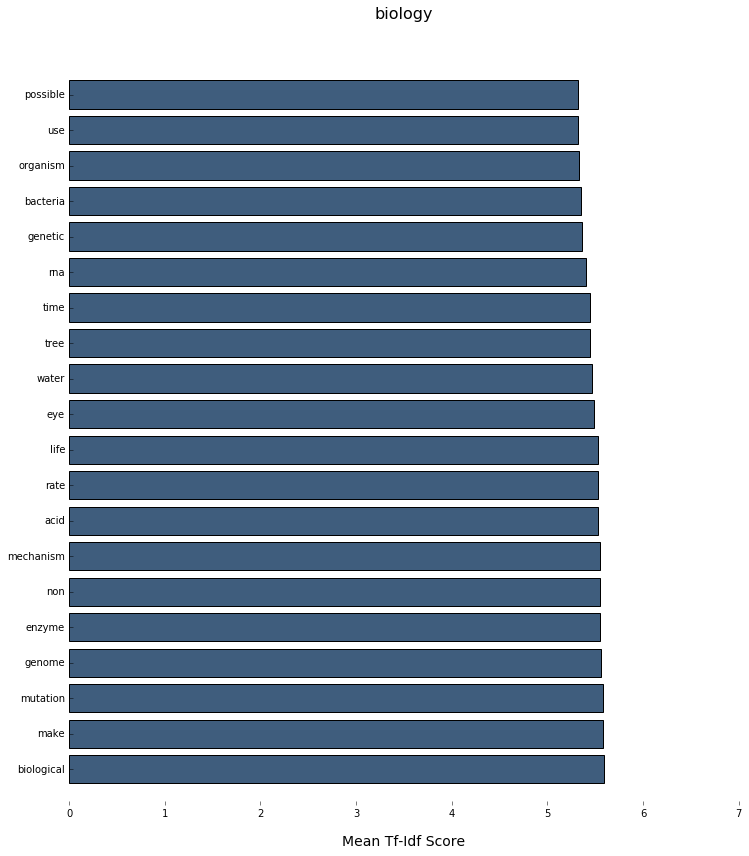

Finding most popular tags


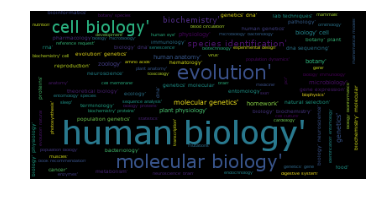

cooking
Finding terms with top tf-idf from question's titles


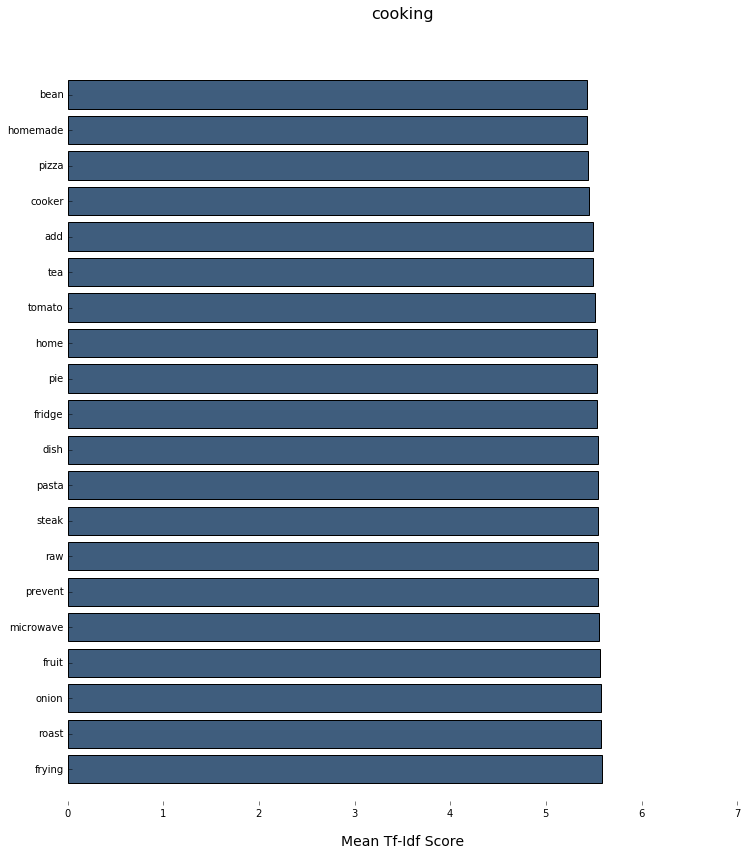

Finding most popular tags


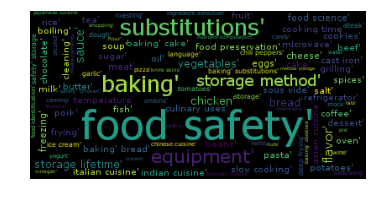

travel
Finding terms with top tf-idf from question's titles


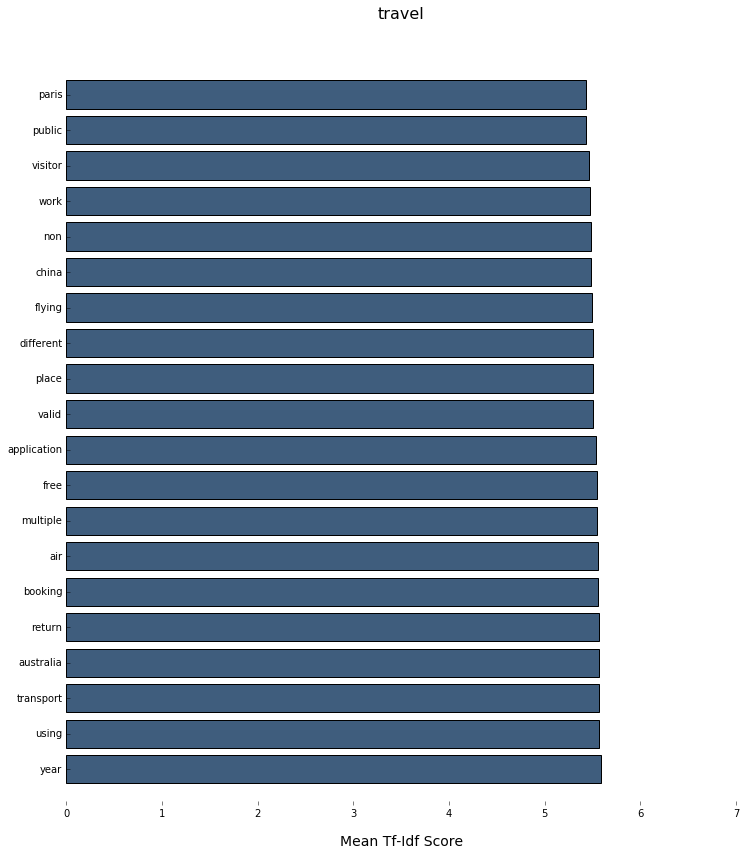

Finding most popular tags


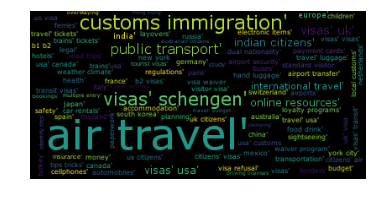

robotics
Finding terms with top tf-idf from question's titles


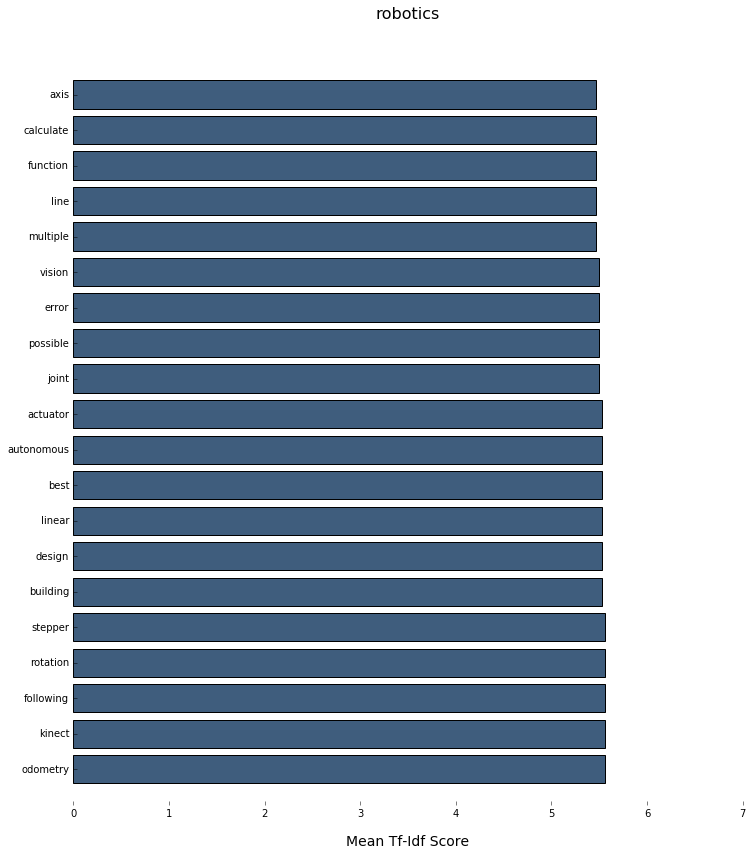

Finding most popular tags


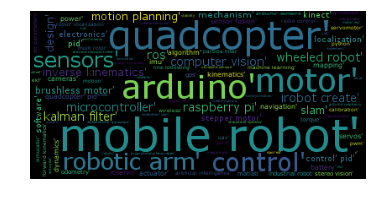

crypto
Finding terms with top tf-idf from question's titles


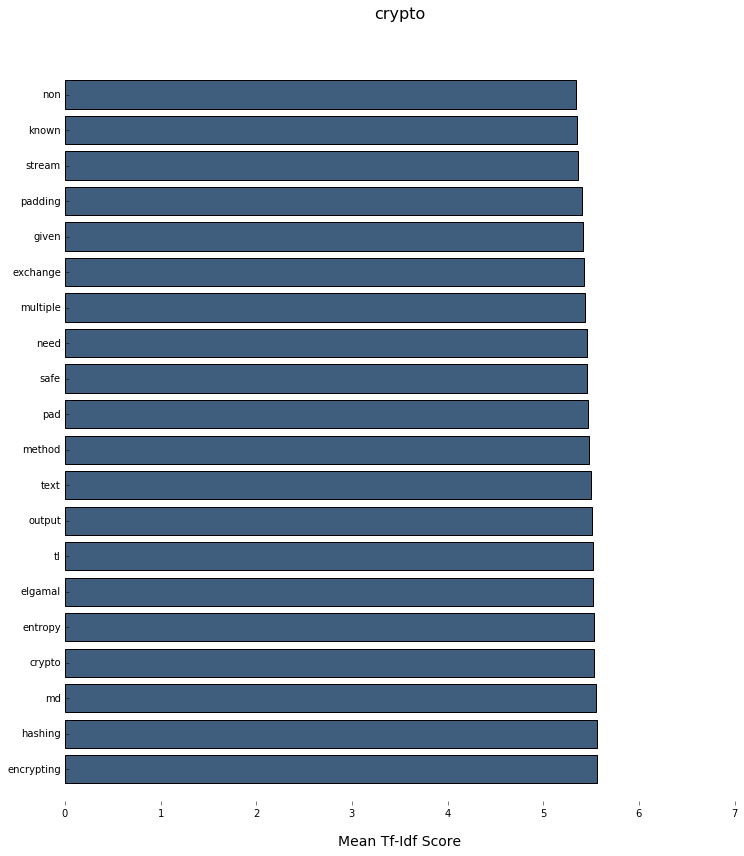

Finding most popular tags


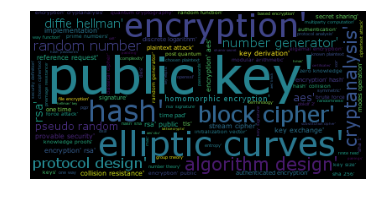

diy
Finding terms with top tf-idf from question's titles


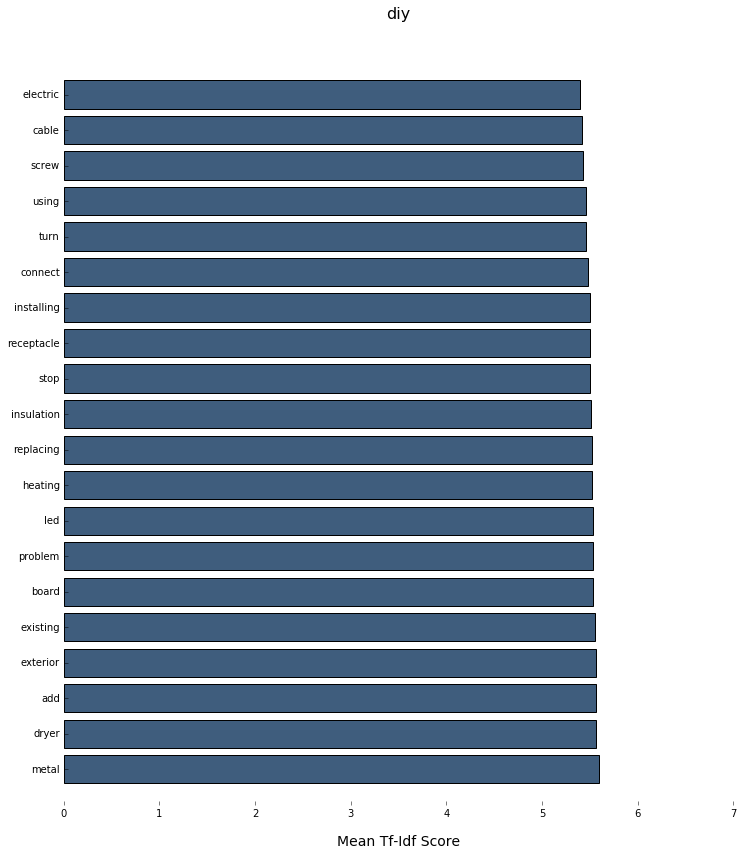

Finding most popular tags


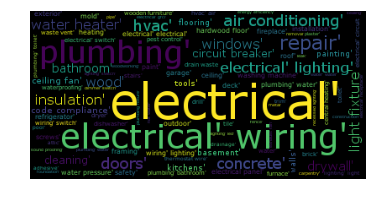

In [8]:
# Data Visualization

from sklearn.feature_extraction.text import TfidfVectorizer

vect_hash = {}

for topic, df in df_hash.iteritems():
    if topic == "test":
        next
    else:
        vect_hash[topic] = TfidfVectorizer( lowercase=True , stop_words="english" ,min_df=.01, max_df= .95 ) 
        X = vect_hash[topic].fit_transform(df.title)

        dfs = top_tfidf_feats( vect_hash[topic].idf_ , vect_hash[topic].get_feature_names()  ) 
        dfs.label = topic
        print topic
        print "Finding terms with top tf-idf from question's titles"
        plot_tfidf_classfeats_h(dfs)
        print "Finding most popular tags"
        print_wordcloud(df)

        

In [9]:
frames = []
for topic, df in df_hash.iteritems():
    frames.append(df)

df_all = pd.concat(frames)
# print df_all.tags


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
    
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [11]:
# Implementation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score, confusion_matrix

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from time import time 
        

# for topic, df in df_hash.iteritems():

parameters = {
    "union__title__tfidf__min_df" : [ 0.001],
    "union__title__tfidf__max_df" : [0.9],
    "union__content__tfidf__min_df" : [ 0.001],
    "union__content__tfidf__max_df" : [0.9],
    "DT_class__estimator__max_depth" : [10, 20],
    "DT_class__estimator__criterion" : ["gini"],
    "union__transformer_weights" :  [{"title": 0.6, "content": 0.4},
                                    {"title": 0.8, "content": 0.2}]
}

steps = [('union', FeatureUnion(
            transformer_list=[
                # Pipeline for tfidf vectorization of the question's title
                ('title', Pipeline([
                    ('selector', Selector(key='title')),
                    ('tfidf', TfidfVectorizer(lowercase=True, stop_words="english") )
                ])),
                # Pipeline for tfidf vectorization of the question's content
                ('content', Pipeline([
                    ('selector', Selector(key='content')),
                    ('tfidf', TfidfVectorizer(lowercase=True, stop_words="english") )
                ]))
            ])),
        ("DT_class", OneVsRestClassifier(DecisionTreeClassifier( random_state = 42)))]

pipeline = Pipeline(steps)
#     X_train, X_test, y_train, y_test_vect = train_test_split(df.content,\
#                                                         Y, \
#                                                         test_size=0.33,\
#                                                         random_state=42)
#     pipeline.fit(X_train, y_train)
#     y_predicted_vect = pipeline.predict(X_test)


mlb = MultiLabelBinarizer()
Y =  pd.DataFrame(mlb.fit_transform(df_all.tags) )

t0 = time()
clf = GridSearchCV(pipeline, parameters, cv=3, scoring='f1_weighted')
clf.fit( df_all, Y )
print("done in %0.3fs" % (time() - t0))


/Users/vlevitas-local/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/Users/vlevitas-local/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  str(classes[c]))
/Users/vlevitas-local/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))
/Users/vlevitas-local/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 26 is present in all training examples.
  str(classes[c]))
/Users/vlevitas-local/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
/Users/vlevitas-local/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 32 is present in all training examples.
  str(classe

done in 85289.974s


In [12]:

# print clf.best_estimator_
print("Best score: %0.3f" % clf.best_score_)
print("Best parameters set:")
best_parameters = clf.best_estimator_.get_params()
print best_parameters
print "\n\n"
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

print "\n\n"
print clf.cv_results_.keys()



Best score: 0.063
Best parameters set:
{'union__title__tfidf__tokenizer': None, 'union__title__tfidf__analyzer': u'word', 'DT_class__estimator__max_depth': 20, 'DT_class__n_jobs': 1, 'DT_class__estimator__max_leaf_nodes': None, 'DT_class__estimator__presort': False, 'DT_class__estimator__min_samples_leaf': 1, 'union__content__steps': [('selector', Selector(key='content')), ('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.001,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None))], 'union__title__tfidf__encoding': u'utf-8', 'union__title': Pipeline(steps=[('selector', Selector(key='title')), ('tfidf', TfidfVectorizer(analyzer=u'wor

In [13]:
fit_params = {
    "union__title__tfidf__min_df" : 0.001,
    "union__title__tfidf__max_df" : 0.9,
    "union__content__tfidf__min_df" : 0.001,
    "union__content__tfidf__max_df" : 0.9,
    "DT_class__estimator__max_depth" : 10,
    "DT_class__estimator__criterion" : "gini",
    "union__transformer_weights" : {"title": 0.75, "content": 0.25}
}

# for topic, df in df_hash.iteritems():
print "evaluating"
t0 = time()
y_prediction =  cross_val_predict(pipeline, df_all, Y,fit_params=fit_params, cv=3 )
print("done in %0.3fs" % (time() - t0))
print "y_prediction: \n"
print y_prediction.shape
print type(y_prediction)
print type(y_prediction[0])
#     print y_predicted_vect.to_dense

Y_inv = mlb.inverse_transform(y_prediction)
#     y_test_inv = mlb.inverse_transform(y_test_vect.values)
#     y_pred_inv = mlb.inverse_transform(y_predicted_vect)
#     y_pred_inv = y_predicted_vect.apply(lambda x: d[x].inverse_transform(x))
#     y_test_inv = y_test_vect.apply(lambda x: d[x].inverse_transform(x))

#     print clf.best_estimator_
print "baallss"
#     print Y_inv
print accuracy_score(Y, y_prediction) 
report = classification_report(Y, y_prediction) 
print(report)

#     print cv.best_score_
#     print cv.best_params_
#     print clf.feature_importances_  
#     model = SelectFromModel(clf, prefit=True)
#     print model





evaluating


ValueError: need more than 1 value to unpack

In [ ]:
# y = mlb.inverse_transform(Y)
index = 0
for actual, pred in zip(df.tags, Y_inv):
        print('index: {0} :: {1} => {2}'.format(index, actual, ', '.join(pred)))
        index = index +1

        

In [ ]:
print y_prediction.shape
# print y_test[0]

In [ ]:
# print confusion_matrix(Y, y_prediction) 
# print y_pred_inv
# print mlb.inverse_transform(0)


https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/

In [ ]:
# Numpy arrays are easy to work with, so convert the result to an 
# array
# train_data_features = train_data_features.toarray()
# report = classification_report(Y, y_prediction) 
# print report
f1_score(Y, y_prediction, average='weighted')